In [58]:
from fastai.collab import *
from fastai.tabular.all import *
from time import *

In [59]:
path = Path('.')
df = pd.read_csv(path/'training_data.csv', delimiter=',', engine='python',
                     header=0)

In [60]:
df.head()

,date,temp,cloud,rain,wind,humidity,barometer,daily_power
0,2012-01-01,12.333333,overcast clouds,no rain,21.333333,89.333333,1007.866667,5.6
1,2012-01-02,7.787234,scattered clouds,no rain,17.212766,81.425532,1009.170213,2.5
2,2012-01-03,8.208333,overcast clouds,rain,32.354167,78.229167,1007.916667,7.6
3,2012-01-04,7.354167,broken clouds,no rain,26.375000,71.041667,1012.687500,15.1
4,2012-01-05,8.292683,broken clouds,rain,39.170732,77.804878,998.219512,13.1


In [61]:
df['cloud'].unique()

array(['overcast clouds', 'scattered clouds', 'broken clouds',
       'few clouds', 'clear sky'], dtype=object)

In [62]:
df['rain'].unique()

array(['no rain', 'rain', 'drizzle', 'snow', 'thunderstorms'],
      dtype=object)

'rain' can be seen as pure caregorical data since they cannot be put into a suitable ordering. However, 'cloud' in this case is ordinal columns. According to the document of OpenWeather API, the order is as follow:

In [63]:
cloud_levels = 'overcast clouds', 'broken clouds', 'scattered clouds', 'few clouds', 'clear sky'

In [64]:
df.isna().sum()

date           0
temp           0
cloud          0
rain           0
wind           0
humidity       0
barometer      0
daily_power    0
dtype: int64

In [65]:
df['cloud'] = df['cloud'].astype('category')
df['cloud'].cat.set_categories(cloud_levels, ordered=True, inplace=True)

Date is useless in predicting the energy production, so we can drop it out

In [66]:
df.drop(labels='date', axis=1, inplace=True)
df.head()

,temp,cloud,rain,wind,humidity,barometer,daily_power
0,12.333333,overcast clouds,no rain,21.333333,89.333333,1007.866667,5.6
1,7.787234,scattered clouds,no rain,17.212766,81.425532,1009.170213,2.5
2,8.208333,overcast clouds,rain,32.354167,78.229167,1007.916667,7.6
3,7.354167,broken clouds,no rain,26.375000,71.041667,1012.687500,15.1
4,8.292683,broken clouds,rain,39.170732,77.804878,998.219512,13.1


fastai determines which columns should be treated as categorical variables by comparing the number of distinct levels in the variable to the value of the max_card variable:

In [67]:
cont_df,cat_df = cont_cat_split(df, max_card = 6, dep_var = 'daily_power')

In [68]:
df[cat_df].nunique()

cloud    5
rain     5
dtype: int64

The data must be normalized before being fed to the neural network:

In [69]:
procs_nn = [Categorify, FillMissing, Normalize]
splits = RandomSplitter()(range_of(df))
to_nn = TabularPandas(df, procs_nn, cat_df, cont_df, splits=splits, y_names='daily_power')

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2731 entries, 0 to 2730
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   temp         2731 non-null   float64 
 1   cloud        2731 non-null   category
 2   rain         2731 non-null   object  
 3   wind         2731 non-null   float64 
 4   humidity     2731 non-null   float64 
 5   barometer    2731 non-null   float64 
 6   daily_power  2731 non-null   float64 
dtypes: category(1), float64(5), object(1)
memory usage: 131.0+ KB


In [71]:
dls = to_nn.dataloaders(1024)

In [72]:
y = to_nn.train.y
y.min(), y.max()

(0.0, 34.0)

In [73]:
from fastai.tabular.all import*

In [74]:
learn = tabular_learner(dls, y_range=(0.1, 33.9), n_out=1, loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0014454397605732083)

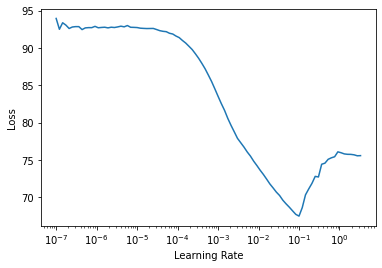

In [75]:
learn.lr_find()

In [76]:
learn.fine_tune(25, 8e-2)

epoch,train_loss,valid_loss,time
0,77.316917,52.858223,00:00


epoch,train_loss,valid_loss,time
0,84.536392,57.582764,00:00
1,73.129684,74.040207,00:00
2,66.890526,72.516350,00:00
3,62.208500,63.807735,00:00
4,59.388947,60.140297,00:00
5,58.210861,67.954086,00:00
6,57.135311,61.597813,00:00
7,56.018669,59.567829,00:00
8,55.224186,52.355080,00:00
9,54.747852,54.115505,00:00
